In [1]:
import os
import itertools
from itertools import combinations

import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from poibin import PoiBin
import pandas as pd
import sys


# import utils
sys.path.append("../")

from data_loading import (load_full_y2h_data_including_controls,
                          load_annotated_gencode_tfs,
                          load_y1h_pdi_data,
                          load_m1h_activation_data,
                          load_valid_isoform_clones,
                          #load_seq_comparison_data,
                          load_gtex_gencode,
                          load_developmental_tissue_expression_gencode,
                          load_tf_families,
                          load_pfam_clans,
                          load_DNA_binding_domains)

# to load alignment function from isolib
from data_loading.isolib import _coords_transform_aa_seq_to_alignment

from plotting import mimic_r_boxplot

In [2]:
np.random.seed(2023)

In [3]:
PAPER_PRESET = {"style": "ticks", "font": "Helvetica", "context": "paper", 
                "rc": {"font.size":7,"axes.titlesize":7,
                       "axes.labelsize":7, 'axes.linewidth':0.5,
                       "legend.fontsize":6, "xtick.labelsize":6,
                       "ytick.labelsize":6, "xtick.major.size": 3.0,
                       "ytick.major.size": 3.0, "axes.edgecolor": "black",
                       "xtick.major.pad": 3.0, "ytick.major.pad": 3.0}}
PAPER_FONTSIZE = 7

sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## 1. load Gencode TFs + GTEx + Dev RNA-seq

In [4]:
tfs = load_annotated_gencode_tfs()

df_gtex, metadata_gtex, genes_gtex = load_gtex_gencode()

exclusion_list_gtex = {'Cells - Leukemia cell line (CML)',
                       'Cells - EBV-transformed lymphocytes',
                       'Cells - Cultured fibroblasts'}

df_gtex = df_gtex.loc[:, ~df_gtex.columns.map(metadata_gtex['body_site']).isin(exclusion_list_gtex)]
metadata_gtex = metadata_gtex.loc[~metadata_gtex['body_site'].isin(exclusion_list_gtex), :]

means_gtex = df_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean()

df_dev, metadata_dev, genes_dev = load_developmental_tissue_expression_gencode()

rename_dev_stage = {'8 week post conception,embryo': '08',
'11 week post conception,late embryo': '11',
'embryo,7 week post conception': '07',
'infant': 'infant',
'10 week post conception,late embryo': '10',
'young adult': 'young adult',
'13 week post conception,late embryo': '13',
'16 week post conception,late embryo': '16',
'4 week post conception,embryo': '04',
'neonate': 'neonate',
'19 week post conception,late embryo': '19',
'9 week post conception,late embryo': '09',
'adolescent': 'adolescent',
'5 week post conception,embryo': '05',
'embryo,6 week post conception': '06',
'12 week post conception,late embryo': '12',
'18 week post conception,late embryo': '18',
'toddler': 'toddler',
'elderly': 'elderly',
'middle adult': 'adult',
'school age child': 'child'}

metadata_dev['dev_stage'] = metadata_dev['Developmental_Stage'].map(rename_dev_stage)
means_dev = (df_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']), axis=1)
           .mean())
all_isos = {'|'.join(sorted(orf.ensembl_transcript_names))
            for tf in tfs.values() for orf in tf.isoforms}
alt_isos = {'|'.join(sorted(orf.ensembl_transcript_names))
            for tf in tfs.values()
            for orf in tf.isoforms
            if tf.has_MANE_select_isoform and not orf.is_MANE_select_transcript}
ref_isos = {'|'.join(sorted(orf.ensembl_transcript_names))
            for tf in tfs.values()
            for orf in tf.isoforms
            if tf.has_MANE_select_isoform and orf.is_MANE_select_transcript}

Filtering GENCODE .gtf file. Takes a few minutes but only needs to be done once.


100%|██████████| 3861/3861 [03:54<00:00, 16.45it/s] 


more than one match for KRK ZFHX3
skipping
more than one match for KRK NFATC1
skipping
more than one match for KRK NFATC1
skipping
more than one match for KRK AKAP8L
skipping
reading from cache
reading from cache


In [5]:
len(tfs)

1635

In [6]:
metadata_dev.shape

(313, 42)

In [7]:
metadata_gtex.shape

(2485, 49)

In [8]:
len(all_isos)

4144

In [9]:
len(ref_isos)

1514

In [10]:
len(alt_isos)

2305

In [11]:
(means_gtex > 1).any(axis=1).value_counts()

True     3165
False     979
dtype: int64

In [12]:
(means_gtex.loc[means_gtex.index.isin(alt_isos), :].sum(axis=1) >= 1).sum()

1842

## 2. isoforms per family

In [13]:
# number of isoforms vs gene expression, publications, and exons 
tpm_per_gene = ((2 ** df_gtex - 1)
                .groupby(genes_gtex)
                .sum()
                .groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1)
                .mean())
gn = tpm_per_gene.max(axis=1).rename('TPM - gene-level, max across GTEx tissues').to_frame()
gn['n_isoforms'] = gn.index.map(genes_gtex.value_counts())

In [14]:
fam = load_tf_families()
gn['family'] = gn.index.map(fam)
gn['is_nuclear_receptor'] = (gn['family'] == 'Nuclear receptor')
gn.head()

,"TPM - gene-level, max across GTEx tissues",n_isoforms,family,is_nuclear_receptor
AC008770.3,0.339530,2,C2H2 ZF,False
AC023509.3,4.475325,1,bZIP,False
AC092835.1,0.884619,1,C2H2 ZF,False
AC138696.1,1.760060,1,C2H2 ZF,False
ADNP,9157.752828,3,Homeodomain,False


In [15]:
len(gn)

1635

In [16]:
len(gn[gn["n_isoforms"] > 1])

992

In [17]:
gn.n_isoforms.mean()

2.5345565749235472

In [18]:
gn[gn["family"] == "Homeodomain"].n_isoforms.mean()

1.8041237113402062

In [19]:
gn[gn["family"] == "Nuclear receptor"].n_isoforms.mean()

3.8260869565217392

In [20]:
gn.sort_values(by="n_isoforms", ascending=False).head()

,"TPM - gene-level, max across GTEx tissues",n_isoforms,family,is_nuclear_receptor
CREM,372.514410,25,bZIP,False
TCF4,13.551768,23,bHLH,False
NFATC4,198.651682,23,Rel,False
NR1I3,65.437841,21,Nuclear receptor,True
MYT1L,47.689698,18,C2H2 ZF,False


In [21]:
fam_members = pd.DataFrame(gn['family'].value_counts()).reset_index()
fam_members_ov20 = fam_members[fam_members["family"] >= 20]
fam_members_ov20

,index,family
0,C2H2 ZF,745
1,Homeodomain,194
2,bHLH,108
3,Unknown,69
4,bZIP,54
5,Forkhead,49
6,Nuclear receptor,46
7,HMG/Sox,30
8,Ets,27


In [22]:
def collapse_families(row, families_to_keep):
    if row['family'] in families_to_keep:
        return row['family']
    else:
        return 'Other'
    
gn['family_updated'] = gn.apply(collapse_families, axis=1, 
                                families_to_keep=list(fam_members[fam_members['family'] >=20]['index']))
gn.family_updated.value_counts()

C2H2 ZF             745
Other               313
Homeodomain         194
bHLH                108
Unknown              69
bZIP                 54
Forkhead             49
Nuclear receptor     46
HMG/Sox              30
Ets                  27
Name: family_updated, dtype: int64

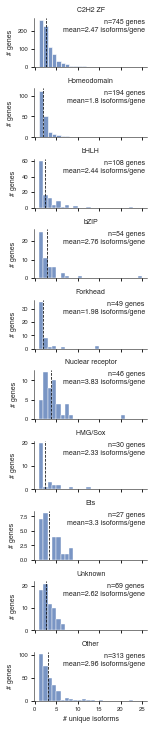

In [23]:
def annotate(data, **kws):
    n = len(data)
    mean = data.n_isoforms.mean()
    ax = plt.gca()
    ax.text(0.98, 0.98, "n=%s genes\nmean=%s isoforms/gene" % (n, np.round(mean, 2)), transform=ax.transAxes,
            ha="right", va="top")
    ax.axvline(x=mean, linestyle="dashed", color="black", linewidth=0.75)

g = sns.FacetGrid(gn, row="family_updated", sharex=True, sharey=False, height=1, aspect=2,
                  row_order=["C2H2 ZF", "Homeodomain", "bHLH", "bZIP", "Forkhead", "Nuclear receptor",
                             "HMG/Sox", "Ets", "Unknown", "Other"])
g.map_dataframe(sns.histplot, "n_isoforms", binwidth=1)
g.map_dataframe(annotate)
g.set_axis_labels("# unique isoforms", "# genes")
g.set_titles(row_template="{row_name}")
g.savefig("../../figures/fig1/GENCODE_iso_counts_per_family.pdf", bbox_inches="tight", dpi="figure")

## 3. downsample GTEx
GTEx has more samples/condition than Dev, but Dev has more conditions

In [24]:
# conditions (body sites): gtex
len(metadata_gtex['body_site'].value_counts())

51

In [25]:
# samples per body site: gtex
metadata_gtex['body_site'].value_counts()

Lung                                         379
Thyroid                                      360
Colon - Transverse                           206
Colon - Sigmoid                              173
Adrenal Gland                                161
Liver                                        138
Kidney - Cortex                               36
Breast - Mammary Tissue                       35
Whole Blood                                   33
Skin - Not Sun Exposed (Suprapubic)           32
Muscle - Skeletal                             32
Skin - Sun Exposed (Lower leg)                29
Adipose - Subcutaneous                        27
Pituitary                                     24
Spleen                                        24
Pancreas                                      24
Brain - Spinal cord (cervical c-1)            24
Heart - Left Ventricle                        24
Uterus                                        24
Brain - Frontal Cortex (BA9)                  24
Brain - Anterior cin

In [26]:
list(metadata_gtex['body_site'].value_counts().index)

['Lung',
 'Thyroid',
 'Colon - Transverse',
 'Colon - Sigmoid',
 'Adrenal Gland',
 'Liver',
 'Kidney - Cortex',
 'Breast - Mammary Tissue',
 'Whole Blood',
 'Skin - Not Sun Exposed (Suprapubic)',
 'Muscle - Skeletal',
 'Skin - Sun Exposed (Lower leg)',
 'Adipose - Subcutaneous',
 'Pituitary',
 'Spleen',
 'Pancreas',
 'Brain - Spinal cord (cervical c-1)',
 'Heart - Left Ventricle',
 'Uterus',
 'Brain - Frontal Cortex (BA9)',
 'Brain - Anterior cingulate cortex (BA24)',
 'Stomach',
 'Brain - Hypothalamus',
 'Brain - Nucleus accumbens (basal ganglia)',
 'Small Intestine - Terminal Ileum',
 'Artery - Coronary',
 'Artery - Aorta',
 'Prostate',
 'Esophagus - Muscularis',
 'Brain - Cortex',
 'Esophagus - Mucosa',
 'Adipose - Visceral (Omentum)',
 'Brain - Caudate (basal ganglia)',
 'Esophagus - Gastroesophageal Junction',
 'Brain - Substantia nigra',
 'Artery - Tibial',
 'Testis',
 'Heart - Atrial Appendage',
 'Brain - Amygdala',
 'Brain - Cerebellar Hemisphere',
 'Brain - Putamen (basal gang

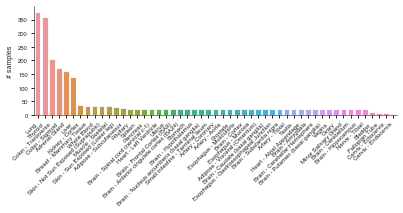

In [27]:
fig = plt.figure(figsize=(6.5, 2))

ax = sns.countplot(data=metadata_gtex, x="body_site", order=list(metadata_gtex['body_site'].value_counts().index))
ax.set_xlabel("")
ax.set_ylabel("# samples")

_ = ax.set_xticklabels(list(metadata_gtex['body_site'].value_counts().index), rotation=45, ha="right", va="top")

for pos in ['top', 'right']:
    ax.spines[pos].set_visible(False)
    
fig.savefig("../../figures/fig1/gtex-metadata.pdf", dpi="figure", bbox_inches="tight")

In [28]:
# conditions (body sites): dev
metadata_dev['body_site'] = metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']
len(metadata_dev['body_site'].value_counts())

127

In [29]:
# samples per body site: dev
metadata_dev['body_site'].value_counts()

hindbrain young adult    5
forebrain young adult    5
forebrain 19             5
hindbrain neonate        5
heart 08                 5
                        ..
heart adolescent         1
testis elderly           1
forebrain 10             1
liver adult              1
liver adolescent         1
Name: body_site, Length: 127, dtype: int64

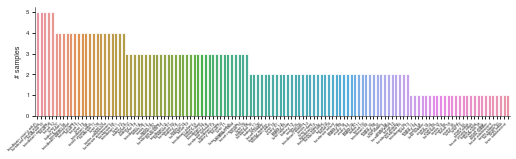

In [30]:
fig = plt.figure(figsize=(8.5, 2))

ax = sns.countplot(data=metadata_dev, x="body_site", order=list(metadata_dev['body_site'].value_counts().index))
ax.set_xlabel("")
ax.set_ylabel("# samples")

_ = ax.set_xticklabels(list(metadata_dev['body_site'].value_counts().index), rotation=45, ha="right", va="top",
                       fontsize=4)

for pos in ['top', 'right']:
    ax.spines[pos].set_visible(False)
    
fig.savefig("../../figures/fig1/dev-metadata.pdf", dpi="figure", bbox_inches="tight")

### loop through GTEx tissues and pick the # of samples by randomly matching to a dev dataset

this is inherently unstable when sampling w/o replacement as will end up with times where there are more samps in the dev that you're randomly matching to than the gtex (rare but happens). set a seed and using the same metadata sampling for all downstream figures.

In [31]:
# loop through gtex tissues
# pick number of samples according to dev dataset
# loop again
# make fake metadata file
n_samples_dev = df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']).value_counts().values
np.random.shuffle(n_samples_dev)
gtex_tissues = metadata_gtex['body_site'].value_counts().index.values

metadata_gtex_dummy = {}
for i, (n_samples, tissue) in enumerate(zip(n_samples_dev, itertools.cycle(gtex_tissues))):
    metadata_gtex_dummy[tissue + '_' + str(i)] = (metadata_gtex.loc[(metadata_gtex['body_site'] == tissue)
                                                                    & ~metadata_gtex.index.isin({s for samples in metadata_gtex_dummy.values() for s in samples}),
                                                                    :]
                                                        .sample(n_samples).index.values)

# TODO: check it is sampling with replacement and ends up same size as dev   
# NOTE: this block of code is unstable depending on seed

metadata_gtex_dummy = (pd.Series({v: k for k, vs in metadata_gtex_dummy.items() for v in vs}, name='body_site')
                         .to_frame())

if metadata_dev.shape[0] != metadata_gtex_dummy.shape[0]:
    raise UserWarning('Problem with downsampling code')
if sorted(n_samples_dev) != sorted(metadata_gtex_dummy.groupby('body_site').size().values):
    raise UserWarning('Problem with downsampling code')
if metadata_gtex_dummy.index.duplicated().any():
    raise UserWarning('Unexpected duplicates')

In [32]:
metadata_gtex_dummy.shape

(313, 1)

In [33]:
len(metadata_gtex_dummy.body_site.unique())

127

In [34]:
len(metadata_gtex_dummy.body_site.str.split("_", expand=True)[0].unique())

51

In [35]:
metadata_dev.shape

(313, 43)

In [36]:
len(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']).unique())

127

In [37]:
df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']).unique()

Index(['liver 12', 'ovary 13', 'hindbrain infant', 'liver adult', 'kidney 12',
       'kidney 10', 'hindbrain adolescent', 'heart 11', 'testis 06',
       'kidney 07',
       ...
       'liver 13', 'kidney 05', 'testis adult', 'ovary 06', 'ovary 05',
       'hindbrain 09', 'kidney toddler', 'forebrain 12', 'testis 12',
       'kidney child'],
      dtype='object', length=127)

In [38]:
tmp = metadata_dev.groupby(["organism_part", "dev_stage"])["BioSample"].agg("count").reset_index()
tmp.sort_values(by="BioSample")

,organism_part,dev_stage,BioSample
103,ovary,11,1
31,heart,18,1
106,ovary,16,1
33,heart,adolescent,1
58,kidney,04,1
...,...,...,...
55,hindbrain,neonate,5
57,hindbrain,young adult,5
19,forebrain,young adult,5
24,heart,08,5


### this dataframe is now the same shape as the dev data in both # of samples and of # of "sites"

gets to the same # of "sites" by re-sampling among GTEx tissues

In [39]:
# write this file so we can load it in later figures
metadata_gtex_dummy.to_csv("../../data/processed/metadata_gtex_dummy.csv")

In [40]:
means_gtex_downsample = df_gtex.groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1).mean()

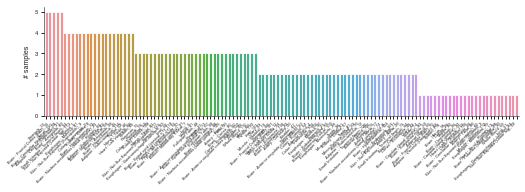

In [41]:
fig = plt.figure(figsize=(8.5, 2))

ax = sns.countplot(data=metadata_gtex_dummy, x="body_site", 
                   order=list(metadata_gtex_dummy['body_site'].value_counts().index))
ax.set_xlabel("")
ax.set_ylabel("# samples")

_ = ax.set_xticklabels(list(metadata_gtex_dummy['body_site'].value_counts().index), rotation=45, ha="right", va="top",
                       fontsize=4)

for pos in ['top', 'right']:
    ax.spines[pos].set_visible(False)
    
fig.savefig("../../figures/fig1/gtex-dummy-metadata.pdf", dpi="figure", bbox_inches="tight")

## 4. histograms: isoforms per gene + thresholded on expression

### GTEx: all

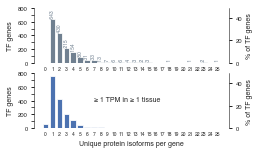

In [42]:
# plot number of isoforms above 1 TPM

fig, axs = plt.subplots(2, 1, sharex=False, figsize=(3.5, 2.2))

n_iso = (means_gtex > 1).any(axis=1).groupby(genes_gtex).size()
x_max = n_iso.max()
xs = range(0, x_max + 1)
axs[0].bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs], color="slategrey")

# label n
for h, x in zip([n_iso.value_counts().to_dict().get(x, 0) for x in xs], xs):
    if h == 0:
        continue
    axs[0].text(x, h, " %s" % h, rotation=90, fontsize=fontsize-2, ha="center", va="bottom",
                color="slategrey")

n_iso = (means_gtex > 1).any(axis=1).groupby(genes_gtex).sum()
axs[1].bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs])

axs[0].set_xticks(xs)
axs[0].set_xlabel("Unique annotated protein isoforms per gene")
axs[0].tick_params(axis='x', labelsize=fontsize-2)
axs[1].set_xticks(xs)
axs[1].tick_params(axis='x', labelsize=fontsize-2)
axs[1].set_xlabel('Unique protein isoforms per gene')
#axs[0].text(x=7, y=400, s='All isoforms')
axs[1].text(x=7, y=400, s='≥ 1 TPM in ≥ 1 tissue')

def num2pct(y):
    return (y / n_iso.shape[0]) * 100

def pct2num(y):
    return (y / 100) * n_iso.shape[0]

for ax in axs:
    ax.set_ylim(0, 800)
    ax.set_yticks(range(0, 800, 100), minor=True)
    ax.set_ylabel('TF genes')
    for pos in ['top', 'right', 'bottom']:
        ax.spines[pos].set_visible(False)
    ax.xaxis.set_tick_params(length=0)
    pctax = ax.secondary_yaxis('right', functions=(num2pct, pct2num))
    pctax.set_ylabel('% of TF genes')
    pctax.set_yticks(range(0, 46, 5), minor=True)
fig.savefig('../../figures/fig1/n-isoforms-per-gene_by-1TPM-cutoff_hist-GTEx.pdf',
            bbox_inches='tight')

### GTEx: downsample

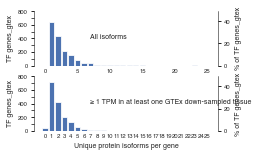

In [43]:
# plot number of isoforms above 1 TPM

fig, axs = plt.subplots(2, 1, sharex=False, figsize=(3.3, 2.2))

n_iso = (means_gtex_downsample > 1).any(axis=1).groupby(genes_gtex).size()
x_max = n_iso.max()
xs = range(0, x_max + 1)
axs[0].bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs])

n_iso = (means_gtex_downsample > 1).any(axis=1).groupby(genes_gtex).sum()
axs[1].bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs])

axs[1].set_xticks(xs)
axs[1].set_xlabel('Unique protein isoforms per gene')
axs[0].text(x=7, y=400, s='All isoforms')
axs[1].text(x=7, y=400, s='≥ 1 TPM in at least one GTEx down-sampled tissue')

for ax in axs:
    ax.set_ylim(0, 800)
    ax.set_yticks(range(0, 800, 100), minor=True)
    ax.set_ylabel('TF genes_gtex')
    for pos in ['top', 'right', 'bottom']:
        ax.spines[pos].set_visible(False)
    ax.xaxis.set_tick_params(length=0)
    pctax = ax.secondary_yaxis('right', functions=(num2pct, pct2num))
    pctax.set_ylabel('% of TF genes_gtex')
    pctax.set_yticks(range(0, 46, 5), minor=True)
fig.savefig('../../figures/fig1/n-isoforms-per-gene_by-1TPM-cutoff_hist-GTEx_downsamp.pdf',
            bbox_inches='tight')

### Dev

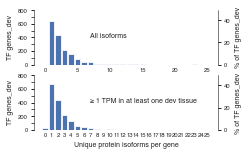

In [44]:
# plot number of isoforms above 1 TPM

fig, axs = plt.subplots(2, 1, sharex=False, figsize=(3.3, 2.2))

n_iso = (means_dev > 1).any(axis=1).groupby(genes_dev).size()
x_max = n_iso.max()
xs = range(0, x_max + 1)
axs[0].bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs])

n_iso = (means_dev > 1).any(axis=1).groupby(genes_dev).sum()
axs[1].bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs])

axs[1].set_xticks(xs)
axs[1].set_xlabel('Unique protein isoforms per gene')
axs[0].text(x=7, y=400, s='All isoforms')
axs[1].text(x=7, y=400, s='≥ 1 TPM in at least one dev tissue')

for ax in axs:
    ax.set_ylim(0, 800)
    ax.set_yticks(range(0, 800, 100), minor=True)
    ax.set_ylabel('TF genes_dev')
    for pos in ['top', 'right', 'bottom']:
        ax.spines[pos].set_visible(False)
    ax.xaxis.set_tick_params(length=0)
    pctax = ax.secondary_yaxis('right', functions=(num2pct, pct2num))
    pctax.set_ylabel('% of TF genes_dev')
    pctax.set_yticks(range(0, 46, 5), minor=True)
fig.savefig('../../figures/fig1/n-isoforms-per-gene_by-1TPM-cutoff_hist-GTEx_dev.pdf',
            bbox_inches='tight')

## 5. ref v alt 2D heatmaps: max expression

In [45]:
ref_alt_map = pd.DataFrame([ref_isos]).T
ref_alt_map.columns = ["ref"]
ref_alt_map["gene"] = ref_alt_map["ref"].str.split("|", expand=True)[0].str[:-4]

alt_isos_df = pd.DataFrame([alt_isos]).T
alt_isos_df.columns = ["alt"]
alt_isos_df["gene"] = alt_isos_df["alt"].str.split("|", expand=True)[0].str[:-4]

ref_alt_map = ref_alt_map.merge(alt_isos_df, on="gene", how="left")
print(len(ref_alt_map))
ref_alt_map_nonan = ref_alt_map[~pd.isnull(ref_alt_map["alt"])]
print(len(ref_alt_map_nonan))
ref_alt_map_nonan.head()

2910
2305


,ref,gene,alt
0,THAP6-201|THAP6-213,THAP6,THAP6-203
1,THAP6-201|THAP6-213,THAP6,THAP6-210
2,THAP6-201|THAP6-213,THAP6,THAP6-212
3,THAP6-201|THAP6-213,THAP6,THAP6-202
4,THAP6-201|THAP6-213,THAP6,THAP6-211


In [46]:
ref_alt_map_nonan[ref_alt_map_nonan["gene"] == "NKX2-5"]

,ref,gene,alt
1844,NKX2-5-201,NKX2-5,NKX2-5-202
1845,NKX2-5-201,NKX2-5,NKX2-5-204


### GTEx: all

In [47]:
means_gtex["max_gtex"] = means_gtex.max(axis=1)
means_gtex["min_gtex"] = means_gtex.min(axis=1)

# max out anything above 11 (2000 tpm) to make plots more readable, as luke did above
means_gtex[means_gtex["max_gtex"] > 11] = 11

print(means_gtex["max_gtex"].max())
print(means_gtex["max_gtex"].min())
means_gtex_ri = means_gtex.reset_index()
means_gtex_ri["UID_rep"] = means_gtex_ri["UID"].str.replace("_", "|")

11.0
0.0


In [48]:
ref_alt_map_nonan = ref_alt_map_nonan.merge(means_gtex_ri[["UID_rep", "max_gtex", "min_gtex"]], left_on="ref", 
                                            right_on="UID_rep", how="inner")
ref_alt_map_nonan = ref_alt_map_nonan.merge(means_gtex_ri[["UID_rep", "max_gtex", "min_gtex"]], left_on="alt", 
                                            right_on="UID_rep", suffixes=("_ref", "_alt"), how="inner")

1775
529


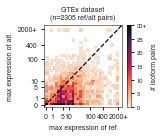

In [49]:
fig = plt.figure(figsize=(1.75, 1.5))

ax = sns.histplot(data=ref_alt_map_nonan, x="max_gtex_ref", y="max_gtex_alt",
                  bins=30, cbar=True, cbar_kws={"label": "# isoform pairs",
                                                "ticks": [0, 5, 10, 15, 20, 25, 30]}, cmap="rocket_r",
                  vmin=0, vmax=30)

ax.set_xlim((-0.3, 11.5))
ax.set_ylim((-0.3, 11.5))
ax.set_xlabel("max expression of ref")
ax.set_ylabel("max expression of alt")
ax.set_title("GTEx dataset\n(n=%s ref/alt pairs)" % len(ref_alt_map_nonan))

ticks = [0, 1, 5, 10, 100, 400, 2000]
ticklabels = [0, 1, 5, 10, 100, 400, "2000+"]
ax.set_xticks([np.log2(x + 1) for x in ticks])
ax.set_xticklabels(ticklabels)
ax.set_yticks([np.log2(y + 1) for y in ticks])
ax.set_yticklabels(ticklabels)
ax.tick_params(axis='x', labelsize=7)
ax.tick_params(axis='y', labelsize=7)

cbar = ax.collections[0].colorbar
cbar.set_ticklabels(["0", "5", "10", "15", "20", "25", "30+"])

# find num where ref > alt
ra = len(ref_alt_map_nonan[ref_alt_map_nonan["max_gtex_ref"] > ref_alt_map_nonan["max_gtex_alt"]])
print(ra)
#ax.text(8.5, 7, "%s\n(%s%%)" % (ra, round(ra/len(ref_alt_map_nonan), 2)*100), ha="left", va="bottom")

# find num where alt > ref
ar = len(ref_alt_map_nonan[ref_alt_map_nonan["max_gtex_ref"] < ref_alt_map_nonan["max_gtex_alt"]])
print(ar)
#ax.text(9, 10.5, "%s\n(%s%%)" % (ar, round(ar/len(ref_alt_map_nonan), 2)*100), ha="right", va="top")

ax.plot([-0.3,11.5], [-0.3, 11.5], color="black", linestyle="dashed")

fig.savefig('../../figures/fig1/expression-scatter-ref_v_alt-gtex.pdf',
            bbox_inches='tight')

### GTEx: downsampled

In [50]:
means_gtex_downsample["max_gtex_downsample"] = means_gtex_downsample.max(axis=1)
means_gtex_downsample["min_gtex_downsample"] = means_gtex_downsample.min(axis=1)

# max out anything above 11 (2000 tpm) to make plots more readable, as luke did above
means_gtex_downsample[means_gtex_downsample["max_gtex_downsample"] > 11] = 11

print(means_gtex_downsample["max_gtex_downsample"].max())
print(means_gtex_downsample["max_gtex_downsample"].min())
means_gtex_downsample_ri = means_gtex_downsample.reset_index()
means_gtex_downsample_ri["UID_rep"] = means_gtex_downsample_ri["UID"].str.replace("_", "|")

11.0
0.0


In [51]:
ref_alt_map_nonan = ref_alt_map_nonan.merge(means_gtex_downsample_ri[["UID_rep", "max_gtex_downsample",
                                                                      "min_gtex_downsample"]], 
                                            left_on="ref", right_on="UID_rep", how="inner")
ref_alt_map_nonan = ref_alt_map_nonan.merge(means_gtex_downsample_ri[["UID_rep", "max_gtex_downsample",
                                                                      "min_gtex_downsample"]], 
                                            left_on="alt", right_on="UID_rep", suffixes=("_ref", "_alt"), how="inner")

1768
536


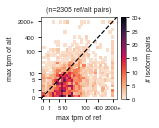

In [52]:
fig = plt.figure(figsize=(1.7, 1.5))

ax = sns.histplot(data=ref_alt_map_nonan, x="max_gtex_downsample_ref", y="max_gtex_downsample_alt",
                  bins=30, cbar=True, cbar_kws={"label": "# isoform pairs",
                                                "ticks": [0, 5, 10, 15, 20, 25, 30]}, cmap="rocket_r",
                  vmin=0, vmax=30)

ax.set_xlim((-0.3, 11.5))
ax.set_ylim((-0.3, 11.5))
ax.set_xlabel("max tpm of ref")
ax.set_ylabel("max tpm of alt")
ax.set_title("(n=%s ref/alt pairs)" % len(ref_alt_map_nonan))

ticks = [0, 1, 5, 10, 100, 400, 2000]
ticklabels = [0, 1, 5, 10, 100, 400, "2000+"]
ax.set_xticks([np.log2(x + 1) for x in ticks])
ax.set_xticklabels(ticklabels)
ax.set_yticks([np.log2(y + 1) for y in ticks])
ax.set_yticklabels(ticklabels)
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)

cbar = ax.collections[0].colorbar
cbar.set_ticklabels(["0", "5", "10", "15", "20", "25", "30+"])

# find num where ref > alt
ra = len(ref_alt_map_nonan[ref_alt_map_nonan["max_gtex_downsample_ref"] > ref_alt_map_nonan["max_gtex_downsample_alt"]])
print(ra)
#ax.text(8.5, 7, "%s\n(%s%%)" % (ra, round(ra/len(ref_alt_map_nonan), 2)*100), ha="left", va="bottom")

# find num where alt > ref
ar = len(ref_alt_map_nonan[ref_alt_map_nonan["max_gtex_downsample_ref"] < ref_alt_map_nonan["max_gtex_downsample_alt"]])
print(ar)
#ax.text(9, 10.5, "%s\n(%s%%)" % (ar, round(ar/len(ref_alt_map_nonan), 2)*100), ha="right", va="top")

ax.plot([-0.3,11.5], [-0.3, 11.5], color="black", linestyle="dashed")

fig.savefig('../../figures/fig1/expression-scatter-ref_v_alt-gtex-downsample.pdf',
            bbox_inches='tight')

### Dev

In [53]:
means_dev["max_dev"] = means_dev.max(axis=1)
means_dev["min_dev"] = means_dev.min(axis=1)

# max out anything above 11 (2000 tpm) to make plots more readable, as luke did above
means_dev[means_dev["max_dev"] > 11] = 11

print(means_dev["max_dev"].max())
print(means_dev["max_dev"].min())
means_dev_ri = means_dev.reset_index()
means_dev_ri["UID_rep"] = means_dev_ri["UID"].str.replace("_", "|")

11.0
0.0


In [54]:
ref_alt_map_nonan = ref_alt_map_nonan.merge(means_dev_ri[["UID_rep", "max_dev", "min_dev"]], left_on="ref", 
                                            right_on="UID_rep", how="inner")
ref_alt_map_nonan = ref_alt_map_nonan.merge(means_dev_ri[["UID_rep", "max_dev", "min_dev"]], left_on="alt", 
                                            right_on="UID_rep", suffixes=("_ref", "_alt"), how="inner")

1752
551


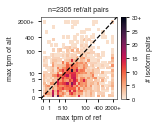

In [55]:
fig = plt.figure(figsize=(1.7, 1.5))

ax = sns.histplot(data=ref_alt_map_nonan, x="max_dev_ref", y="max_dev_alt",
                  bins=30, cbar=True, cbar_kws={"label": "# isoform pairs",
                                                "ticks": [0, 5, 10, 15, 20, 25, 30]}, cmap="rocket_r",
                  vmin=0, vmax=30)

ax.set_xlim((-0.3, 11.5))
ax.set_ylim((-0.3, 11.5))
ax.set_xlabel("max tpm of ref")
ax.set_ylabel("max tpm of alt")
ax.set_title("n=%s ref/alt pairs" % len(ref_alt_map_nonan))

ticks = [0, 1, 5, 10, 100, 400, 2000]
ticklabels = [0, 1, 5, 10, 100, 400, "2000+"]
ax.set_xticks([np.log2(x + 1) for x in ticks])
ax.set_xticklabels(ticklabels)
ax.set_yticks([np.log2(y + 1) for y in ticks])
ax.set_yticklabels(ticklabels)
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)

cbar = ax.collections[0].colorbar
cbar.set_ticklabels(["0", "5", "10", "15", "20", "25", "30+"])

# find num where ref > alt
ra = len(ref_alt_map_nonan[ref_alt_map_nonan["max_dev_ref"] > ref_alt_map_nonan["max_dev_alt"]])
print(ra)
#ax.text(8.5, 7, "%s\n(%s%%)" % (ra, round(ra/len(ref_alt_map_nonan), 2)*100), ha="left", va="bottom")

# find num where alt > ref
ar = len(ref_alt_map_nonan[ref_alt_map_nonan["max_dev_ref"] < ref_alt_map_nonan["max_dev_alt"]])
print(ar)
#ax.text(9, 10.5, "%s\n(%s%%)" % (ar, round(ar/len(ref_alt_map_nonan), 2)*100), ha="right", va="top")

ax.plot([-0.3,11.5], [-0.3, 11.5], color="black", linestyle="dashed")

fig.savefig('../../figures/fig1/expression-scatter-ref_v_alt-dev.pdf',
            bbox_inches='tight')

## 6. per isoform: max v min ratio

removing NaNs - not counting anything where *gene* expression < 1

### GTEx: all

In [56]:
# percentage of alternative isoform
# plot distribution of fraction of gene expression for ref and alt

# fraction where gene tpm > 1

per_gene_gtex = ((2 ** df_gtex - 1)
                .groupby(genes_gtex)
                .transform('sum'))
f_gtex = (((2 ** df_gtex - 1) / per_gene_gtex)
        .groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1)
        .mean())
f_gtex = f_gtex * (per_gene_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean() >= 1).applymap(lambda x: {False: np.nan, True: 1}[x])  # only count fractions if gene TPM is >= 1

f_gtex = f_gtex * 100

In [57]:
print(len(f_gtex))
f_gtex["max_ratio_gtex"] = f_gtex.max(axis=1)
f_gtex["min_ratio_gtex"] = f_gtex.min(axis=1)
f_gtex_nonan = f_gtex[(~pd.isnull(f_gtex["max_ratio_gtex"])) & (~pd.isnull(f_gtex["min_ratio_gtex"]))]
print(len(f_gtex_nonan))

f_gtex_ri = f_gtex_nonan.reset_index()
f_gtex_ri["UID_rep"] = f_gtex_ri["UID"].str.replace("_", "|")

4144
4095


In [58]:
ref_alt_map_nonan = ref_alt_map_nonan.merge(f_gtex_ri[["UID_rep", "max_ratio_gtex", "min_ratio_gtex"]], left_on="ref", 
                                            right_on="UID_rep", how="left")
ref_alt_map_nonan = ref_alt_map_nonan.merge(f_gtex_ri[["UID_rep", "max_ratio_gtex", "min_ratio_gtex"]], left_on="alt", 
                                            right_on="UID_rep", suffixes=("_ref", "_alt"), how="left")

### GTEx: downsample

In [59]:
# percentage of alternative isoform
# plot distribution of fraction of gene expression for ref and alt

# has to be fraction where isoform TPM is at least 1, right (fill na with 0)

per_gene_gtex = ((2 ** df_gtex - 1)
                .groupby(genes_gtex)
                .transform('sum'))
f_gtex_downsample = (((2 ** df_gtex - 1) / per_gene_gtex)
        .groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1)
        .mean())
f_gtex_downsample = f_gtex_downsample * (per_gene_gtex.groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1).mean() >= 1).applymap(lambda x: {False: np.nan, True: 1}[x])  # only count fractions if gene TPM is >= 1

f_gtex_downsample = f_gtex_downsample * 100

In [60]:
print(len(f_gtex_downsample))
f_gtex_downsample["max_ratio_gtex_downsample"] = f_gtex_downsample.max(axis=1)
f_gtex_downsample["min_ratio_gtex_downsample"] = f_gtex_downsample.min(axis=1)
f_gtex_downsample_nonan = f_gtex_downsample[(~pd.isnull(f_gtex_downsample["max_ratio_gtex_downsample"])) & 
                                            (~pd.isnull(f_gtex_downsample["min_ratio_gtex_downsample"]))]
print(len(f_gtex_downsample_nonan))

f_gtex_downsample_ri = f_gtex_downsample_nonan.reset_index()
f_gtex_downsample_ri["UID_rep"] = f_gtex_downsample_ri["UID"].str.replace("_", "|")

4144
4099


In [61]:
ref_alt_map_nonan = ref_alt_map_nonan.merge(f_gtex_downsample_ri[["UID_rep", "max_ratio_gtex_downsample", 
                                                       "min_ratio_gtex_downsample"]], left_on="ref", 
                                            right_on="UID_rep", how="left")
ref_alt_map_nonan = ref_alt_map_nonan.merge(f_gtex_downsample_ri[["UID_rep", "max_ratio_gtex_downsample", 
                                                                  "min_ratio_gtex_downsample"]], left_on="alt", 
                                            right_on="UID_rep", suffixes=("_ref", "_alt"), how="left")


### Dev

In [62]:
# percentage of alternative isoform
# plot distribution of fraction of gene expression for ref and alt

# has to be fraction where isoform TPM is at least 1, right (fill na with 0)

per_gene_dev = ((2 ** df_dev - 1)
                .groupby(genes_dev)
                .transform('sum'))
f_dev = (((2 ** df_dev - 1) / per_gene_dev)
        .groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
         axis=1)
        .mean())
f_dev = f_dev * ((per_gene_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
                                             axis=1)
                                             .mean() >= 1)
                                         .applymap(lambda x: {False: np.nan, True: 1}[x]))  # only count fractions if gene TPM is >= 1

f_dev = f_dev * 100

In [63]:
print(len(f_dev))
f_dev["max_ratio_dev"] = f_dev.max(axis=1)
f_dev["min_ratio_dev"] = f_dev.min(axis=1)
f_dev_nonan = f_dev[(~pd.isnull(f_dev["max_ratio_dev"])) & (~pd.isnull(f_dev["min_ratio_dev"]))]
print(len(f_dev_nonan))

f_dev_ri = f_dev_nonan.reset_index()
f_dev_ri["UID_rep"] = f_dev_ri["UID"].str.replace("_", "|")

4144
4119


In [64]:
ref_alt_map_nonan = ref_alt_map_nonan.merge(f_dev_ri[["UID_rep", "max_ratio_dev", "min_ratio_dev"]], left_on="ref", 
                                            right_on="UID_rep", how="left")
ref_alt_map_nonan = ref_alt_map_nonan.merge(f_dev_ri[["UID_rep", "max_ratio_dev", "min_ratio_dev"]], left_on="alt", 
                                            right_on="UID_rep", suffixes=("_ref", "_alt"), how="left")

## 2D histograms to display shift/switch + barplots to quantify

In [65]:
print(len(ref_alt_map_nonan))
df = ref_alt_map_nonan[["gene", "ref", "alt", "min_ratio_dev_alt", "max_ratio_dev_alt",
                        "min_ratio_gtex_downsample_alt", "max_ratio_gtex_downsample_alt"]].drop_duplicates()
print(len(df))

df["perc_change_dev_alt"] = df["max_ratio_dev_alt"] - df["min_ratio_dev_alt"]
df["perc_change_gtex_downsample_alt"] = df["max_ratio_gtex_downsample_alt"] - df["min_ratio_gtex_downsample_alt"]

2305
2305


In [66]:
LOW_THRESH = 10
PERC_CHANGE_THRESH = 70

In [67]:
def categorize_switch(row, min_col, max_col, perc_change_col, LOW_THRESH=LOW_THRESH, PERC_CHANGE_THRESH=PERC_CHANGE_THRESH):
    if row[min_col] < LOW_THRESH and row[max_col] < LOW_THRESH:
        return "low"
    elif row[perc_change_col] > PERC_CHANGE_THRESH:
        return "switch"
    else:
        return "shift"

df["cat_dev_alt"] = df.apply(categorize_switch, min_col="min_ratio_dev_alt", max_col="max_ratio_dev_alt", 
                             perc_change_col="perc_change_dev_alt", axis=1)
df["cat_gtex_downsample_alt"] = df.apply(categorize_switch, min_col="min_ratio_gtex_downsample_alt", 
                                         max_col="max_ratio_gtex_downsample_alt", 
                                         perc_change_col="perc_change_gtex_downsample_alt", 
                                         axis=1)

In [68]:
df.cat_dev_alt.value_counts()

shift     1482
switch     478
low        345
Name: cat_dev_alt, dtype: int64

In [69]:
df.cat_gtex_downsample_alt.value_counts()

shift     1567
low        474
switch     264
Name: cat_gtex_downsample_alt, dtype: int64

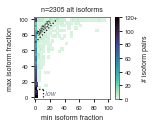

In [70]:
fig = plt.figure(figsize=(1.7, 1.5))

ax = sns.histplot(data=df, x="min_ratio_dev_alt", y="max_ratio_dev_alt",
                  bins=30, cbar=True, cmap="mako_r", vmin=0, vmax=120, cbar_kws={"label": "# isoform pairs",
                                                                                   "ticks": [0, 20, 40, 60,
                                                                                             80, 100, 120]})
cbar = ax.collections[0].colorbar
cbar.set_ticklabels(["0", "20", "40", "60", "80", "100", "120+"])
ax.set_xlim((-2, 102))
ax.set_ylim((-2, 102))
ax.set_xticks([0, 20, 40, 60, 80, 100])
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_xlabel("min isoform fraction")
ax.set_ylabel("max isoform fraction")
ax.set_title("n=%s alt isoforms" % len(df))

# add lines to distinguish events
ax.plot([LOW_THRESH, 0], [LOW_THRESH, LOW_THRESH], linestyle="dotted", color="black")
ax.plot([LOW_THRESH, LOW_THRESH], [0, LOW_THRESH], linestyle="dotted", color="black")
ax.text(LOW_THRESH, 5, " low", ha="left", va="center", fontstyle="italic", color="slategrey")
ax.plot([0, 100-PERC_CHANGE_THRESH], [PERC_CHANGE_THRESH, 100], linestyle="dotted", color="black")
ax.text(0, PERC_CHANGE_THRESH, "switch\n", ha="left", va="bottom", rotation=45, fontstyle="italic", color="black")
fig.savefig('../../figures/fig1/expression-ratio-scatter-alt-dev.pdf',
            bbox_inches='tight')

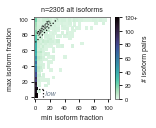

In [71]:
fig = plt.figure(figsize=(1.7, 1.5))

ax = sns.histplot(data=df, x="min_ratio_gtex_downsample_alt", y="max_ratio_gtex_downsample_alt",
                  bins=30, cbar=True, cmap="mako_r", vmin=0, vmax=120, cbar_kws={"label": "# isoform pairs",
                                                                                   "ticks": [0, 20, 40, 60,
                                                                                             80, 100, 120]})
cbar = ax.collections[0].colorbar
cbar.set_ticklabels(["0", "20", "40", "60", "80", "100", "120+"])
ax.set_xlim((-2, 102))
ax.set_ylim((-2, 102))
ax.set_xticks([0, 20, 40, 60, 80, 100])
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_xlabel("min isoform fraction")
ax.set_ylabel("max isoform fraction")
ax.set_title("n=%s alt isoforms" % len(df))

# add lines to distinguish events
ax.plot([LOW_THRESH, 0], [LOW_THRESH, LOW_THRESH], linestyle="dotted", color="black")
ax.plot([LOW_THRESH, LOW_THRESH], [0, LOW_THRESH], linestyle="dotted", color="black")
ax.text(LOW_THRESH, 5, " low", ha="left", va="center", fontstyle="italic", color="slategrey")
ax.plot([0, 100-PERC_CHANGE_THRESH], [PERC_CHANGE_THRESH, 100], linestyle="dotted", color="black")
ax.text(0, PERC_CHANGE_THRESH, "switch\n", ha="left", va="bottom", rotation=45, fontstyle="italic", color="black")
fig.savefig('../../figures/fig1/expression-ratio-scatter-alt-gtex-downsample.pdf',
            bbox_inches='tight')

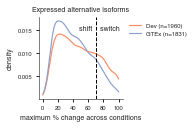

In [72]:
fig = plt.figure(figsize=(1.5, 1.5))

dev_df = df[df["cat_dev_alt"] != "low"].drop_duplicates()
gtex_df = df[df["cat_gtex_downsample_alt"] != "low"].drop_duplicates()
ax = sns.kdeplot(x=dev_df["perc_change_dev_alt"], cumulative=False, cut=0,
                 color=sns.color_palette("Set2")[1], label="Dev (n=%s)" % (len(dev_df)))
sns.kdeplot(x=gtex_df["perc_change_gtex_downsample_alt"], cut=0, 
            cumulative=False, color=sns.color_palette("Set2")[2], label="GTEx (n=%s)" % len(gtex_df), ax=ax)
ax.axvline(x=PERC_CHANGE_THRESH, color="black", linestyle="dashed", linewidth=1)
ax.text(PERC_CHANGE_THRESH, 0.016, "  switch", ha="left", va="top", fontsize=7)
ax.text(PERC_CHANGE_THRESH, 0.016, "shift  ", ha="right", va="top", fontsize=7)


plt.legend(loc=2, bbox_to_anchor=(1.01, 1), frameon=False)

ax.set_xlabel("maximum % change across conditions")
ax.set_ylabel("density")
ax.set_title("Expressed alternative isoforms")

_ = ax.set_xticks([0, 20, 40, 60, 80, 100])

for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)

fig.savefig('../../figures/fig1/perc-change-dist-gtex-v-dev.pdf',
            bbox_inches='tight')

In [73]:
barp = pd.DataFrame(df.cat_dev_alt.value_counts())
barp["cat_dev_alt_p"] = barp["cat_dev_alt"]/barp["cat_dev_alt"].sum(axis=0)*100

barp = barp.join(pd.DataFrame(df.cat_gtex_downsample_alt.value_counts()))
barp["cat_gtex_downsample_alt_p"] = barp["cat_gtex_downsample_alt"]/barp["cat_gtex_downsample_alt"].sum(axis=0)*100
barp = barp[["cat_dev_alt_p", "cat_gtex_downsample_alt_p"]].T.reset_index()
barp

,index,shift,switch,low
0,cat_dev_alt_p,64.295011,20.737527,14.967462
1,cat_gtex_downsample_alt_p,67.982646,11.453362,20.563991


In [74]:
palette = {"low": "lightgrey",
           "shift": sns.color_palette("mako")[1],
           "switch": sns.color_palette("mako")[5]}

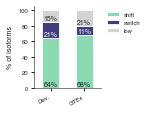

In [75]:
ax = barp.plot.bar(x="index", stacked=True, color=list(palette.values())[::-1], figsize=(1.2, 1.5))
ax.set_ylabel("% of isoforms")
ax.set_xlabel("")

plt.legend(loc=2, bbox_to_anchor=(1.01, 1), frameon=False)
ax.set_xticklabels(["Dev.", "GTEx"], ha="right", va="top", rotation=30)

for i, row in barp.iterrows():
    p_shift = row['shift']
    ax.text(i, 0, '{:.0f}%'.format(p_shift), ha="center", va="bottom", fontsize=7)
    p_switch = row['switch']
    ax.text(i, p_shift, '{:.0f}%'.format(p_switch), ha="center", va="bottom", fontsize=7, color="white")
    p_low = row['low']
    ax.text(i, p_shift+p_switch, '{:.0f}%'.format(p_low), ha="center", va="bottom", fontsize=7)
    
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)

plt.savefig('../../figures/fig1/expression-switch-bar-dev_vs_gtex.pdf',
            bbox_inches='tight')

### example plot: TF gene whose isoform ratios change across tissues

In [76]:
tmp = ref_alt_map_nonan
tmp["mm_gtex_ds_ref"] = tmp["max_ratio_gtex_downsample_ref"]-tmp["min_ratio_gtex_downsample_ref"]
tmp["mm_gtex_ds_alt"] = tmp["max_ratio_gtex_downsample_alt"]-tmp["min_ratio_gtex_downsample_alt"]
tmp["mm_dev_ref"] = tmp["max_ratio_dev_ref"]-tmp["min_ratio_dev_ref"]
tmp["mm_dev_alt"] = tmp["max_ratio_dev_alt"]-tmp["min_ratio_dev_alt"]
tmp["dg_ref"] = tmp["mm_dev_ref"]-tmp["mm_gtex_ds_ref"]
tmp["dg_alt"] = tmp["mm_dev_alt"]-tmp["mm_gtex_ds_alt"]
#tmp.sort_values(by="dg_alt", ascending=False).head(30)

In [77]:
if not (genes_gtex == genes_dev).all():
        raise UserWarning()
genes = genes_gtex

In [78]:
def developmental_tissue_expression_plot(gene_name, palette_name, figsize, ylim, means, cols, fig_suffix):
    n_isos = len(means.loc[genes == gene_name])
    palette = sns.color_palette(palette_name, as_cmap=False, n_colors=n_isos)
    fig, axes = plt.subplots(2, 1, sharex=True)
    fig.set_size_inches(figsize)
    ### bar chart ###
    (means.loc[genes == gene_name, cols]
          .T
          .plot.bar(ax=axes[0],
                    legend=False,
                    width=0.7,
                    color=list(palette)))
    ### percentages ###
    raw_means = 2 ** means.loc[genes == gene_name, cols] - 1.
    (raw_means.div(raw_means.sum(axis=0))
              .T.plot.bar(ax=axes[1], 
                          stacked=True,
                          legend=False,
                          color=list(palette)))
    axes[0].set_ylabel('log2(tpm + 1)\n')
    axes[0].set_ylim(ylim)
    axes[1].set_ylabel('percent')
    axes[1].set_yticklabels(['{:.0%}'.format(t) for t in axes[1].get_yticks()])
    axes[1].legend(loc='lower left', bbox_to_anchor=(1, 0), frameon=False)
    axes[0].axhline(y=1, color='black', linewidth=0.5, linestyle="dashed")
    
    for spine in ['right', 'top']:
        axes[0].spines[spine].set_visible(False)
        axes[1].spines[spine].set_visible(False)
    
    plt.subplots_adjust(hspace=0.25)
    plt.savefig('../../figures/fig1/expression_' + gene_name + '_' + fig_suffix + '.pdf',
                bbox_inches='tight')

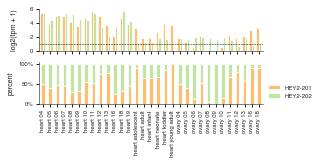

In [79]:
heart_cols = [x for x in means_dev.columns if "heart" in x]
ovary_cols = [x for x in means_dev.columns if "ovary" in x]
developmental_tissue_expression_plot("HEY2", "Spectral", (4, 1.75), (0, 6), means_dev, heart_cols + ovary_cols, 
                                     "means_dev_heart_ovary")

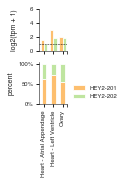

In [80]:
heart_cols = [x for x in means_gtex.columns if "Heart" in x]
ovary_cols = [x for x in means_gtex.columns if "Ovary" in x]
developmental_tissue_expression_plot("HEY2", "Spectral", (0.5, 1.75), (0, 6), means_gtex, heart_cols + ovary_cols, 
                                     "means_gtex_heart_ovary")

In [81]:
ss_alt_gtex = len(ref_alt_map_nonan[(ref_alt_map_nonan["max_ratio_gtex_downsample_alt"] > LOW_THRESH)].gene.unique())
ss_alt_gtex

848

In [82]:
ss_alt_dev = len(ref_alt_map_nonan[(ref_alt_map_nonan["max_ratio_dev_alt"] > LOW_THRESH)].gene.unique())
ss_alt_dev

877

In [83]:
tot_genes = len(ref_alt_map_nonan.gene.unique())
tot_genes

909

In [84]:
ss_alt_gtex/tot_genes

0.9328932893289329

In [85]:
ss_alt_dev/tot_genes

0.9647964796479648

## 7. calculate domain switches in annotated isoforms

In [86]:
clans = load_pfam_clans()
dbd = load_DNA_binding_domains()

In [87]:
pfam = pd.read_csv('../../data/external/Pfam-A.clans.tsv',
                   sep='\t',
                   names=['pfam_accession', 'clan', 'clan_name', 'short_name', 'name'])

In [88]:
ref_isos = dict([(tf.name, orf.name)
            for tf in tfs.values()
            for orf in tf.isoforms
            if tf.has_MANE_select_isoform and orf.is_MANE_select_transcript])
ref_isos['TBX5']

'TBX5-201'

In [89]:
# now every comparison is alt vs annotated reference isoform
df = pd.concat([g.aa_feature_disruption(ref_isos[g.name]) for g in tfs.values() if g.has_MANE_select_isoform])
df.head()

,gene_symbol,ref_iso,alt_iso,accession,category,start_in_ref_iso,end_in_ref_iso,length,deletion,insertion,frameshift
0,PRDM16,PRDM16-201,PRDM16-203,PF00096,Pfam_domain,229,251,22,0,0,0
1,PRDM16,PRDM16-201,PRDM16-206,PF00096,Pfam_domain,229,251,22,0,0,0
2,PRDM16,PRDM16-201,PRDM16-208,PF00096,Pfam_domain,229,251,22,0,0,0
3,PRDM16,PRDM16-201,PRDM16-203,PF00856,Pfam_domain,94,209,115,0,0,0
4,PRDM16,PRDM16-201,PRDM16-206,PF00856,Pfam_domain,94,209,115,0,1,0


In [90]:
# NES/NLS are annotated as UniProt motif
df.category.value_counts()

DBD_flank          7022
effector_domain    6444
Pfam_domain        4741
ZF_array           1216
UniProt motif       376
Name: category, dtype: int64

In [91]:
# loop through ref/alt pairs and calculate the % change in aas by domain type and mut type (del/ins/fs)

dom_types = ["Pfam_domain", "effector_domain", "UniProt motif"]
dom_names = ["Pfam", "effector", "NLS/NES"]


df_pairs = df[["gene_symbol", "ref_iso", "alt_iso"]].drop_duplicates()

dom_df = pd.DataFrame()
for i, row in df_pairs.iterrows():
    dom_sub = df[(df["gene_symbol"] == row.gene_symbol) &
                 (df["ref_iso"] == row.ref_iso) &
                 (df["alt_iso"] == row.alt_iso)]
    
    pp_str = tfs[row.gene_symbol].pairwise_changes_relative_to_reference(row.ref_iso, row.alt_iso)
    
    dom_dict_ = {}
    for dom_type, dom_name in zip(dom_types, dom_names):
        
        dom_sub_t = dom_sub[dom_sub["category"] == dom_type]
        
        nucs = []
        for j, row_j in dom_sub_t.iterrows():
            
            # correctly re-aligns domain coordinates if there are any insertions
            algned_start = _coords_transform_aa_seq_to_alignment(row_j.start_in_ref_iso, pp_str)
            algned_end = _coords_transform_aa_seq_to_alignment(row_j.end_in_ref_iso - 1, pp_str) + 1
            nuc_range = list(range(algned_start, algned_end))
            nucs.append(nuc_range)
        nucs = [item for sublist in nucs for item in sublist]
        nucs = sorted(set(nucs))
        
        pp_str_nucs = ''.join([pp_str[nuc] for nuc in nucs])
        
        if len(nucs) > 0:
            n_ins = pp_str_nucs.count("I")
            n_dd = pp_str_nucs.count("D")
            n_fs = pp_str_nucs.count("F") + pp_str_nucs.count("f")
            #print("dom: %s | ins: %s | dd: %s | fs: %s" % (dom_type, n_ins, n_dd, n_fs))

            # calculate percentage as compared to the domain length
            p_ins = n_ins/len(nucs)*100
            p_dd = n_dd/len(nucs)*100
            p_fs = n_fs/len(nucs)*100
        else:
            p_ins = np.nan
            p_dd = np.nan
            p_fs = np.nan
        
        dom_dict_[dom_name] = {"p_ins": p_ins, "p_dd": p_dd, "p_fs": p_fs}
        
    # also calculate total number of ins/dd/fs
    n_ins = pp_str.count("I")
    n_dd = pp_str.count("D")
    n_fs = pp_str.count("F") + pp_str.count("f")
    
    # calculate percentage as compared to total aa seq len
    p_ins = n_ins/len(pp_str)*100
    p_dd = n_dd/len(pp_str)*100
    p_fs = n_fs/len(pp_str)*100
        
    dom_dict_["total"] = {"p_ins": p_ins, "p_dd": p_dd, "p_fs": p_fs}
    
    dom_df_ = pd.DataFrame.from_dict(dom_dict_, orient="index").reset_index()
    dom_df_["ref_iso"] = row.ref_iso
    dom_df_["alt_iso"] = row.alt_iso
    
    dom_df = dom_df.append(dom_df_)

In [92]:
# first plot overall changes
dom_tot_df = dom_df[dom_df["index"] == "total"]
dom_tot_df = pd.melt(dom_tot_df, id_vars=["ref_iso", "alt_iso", "index"])
dom_tot_df.head()

,ref_iso,alt_iso,index,variable,value
0,PRDM16-201,PRDM16-203,total,p_ins,0.000000
1,PRDM16-201,PRDM16-206,total,p_ins,0.078309
2,PRDM16-201,PRDM16-208,total,p_ins,0.078309
3,TP73-208,TP73-201,total,p_ins,0.000000
4,TP73-208,TP73-202,total,p_ins,0.000000


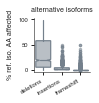

In [93]:
fig = plt.figure(figsize=(1, 1))
ax = sns.boxplot(data=dom_tot_df, 
                 x="variable", y="value", order=["p_dd", "p_ins", "p_fs"],
                 color="slategrey", fliersize=5, notch=True,
                 flierprops={"marker": "."})
mimic_r_boxplot(ax)


ax.set_xlabel("")
ax.set_xticklabels(["deletions", "insertions", "frameshift"], rotation=30, ha="right", va="top")
ax.set_ylabel("% ref. iso. AA affected")
ax.set_title("alternative isoforms")
# handles, labels = ax.get_legend_handles_labels()
# labels = ["all", "Pfam", "effector"]
# ax.legend(handles, labels, loc=2, bbox_to_anchor=(1.01, 1), frameon=False)

for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)

fig.savefig('../../figures/fig1/seq-change-overall-boxplot.pdf',
            bbox_inches='tight')

In [94]:
dom_tot_df.groupby(["variable"]).agg("median")

,value
variable,
p_dd,18.761358
p_fs,0.000000
p_ins,0.525420


In [95]:
print("# alt isos that show >10% deletions")
len(dom_tot_df[(dom_tot_df["variable"] == "p_dd") & (dom_tot_df["value"] >= 10)].alt_iso.unique())

# alt isos that show >10% deletions


1462

In [96]:
print("# alt isos that show >10% insertions")
len(dom_tot_df[(dom_tot_df["variable"] == "p_ins") & (dom_tot_df["value"] >= 10)].alt_iso.unique())

# alt isos that show >10% insertions


195

In [97]:
print("# alt isos that show >10% frameshifts")
len(dom_tot_df[(dom_tot_df["variable"] == "p_fs") & (dom_tot_df["value"] >= 10)].alt_iso.unique())

# alt isos that show >10% frameshifts


68

In [98]:
len(dom_tot_df.alt_iso.unique())

2298

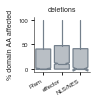

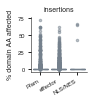

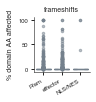

In [99]:
for mut_type, mut_name in zip(["p_dd", "p_ins", "p_fs"], ["deletions", "insertions", "frameshifts"]):
    
    dom_mut_df = pd.melt(dom_df, id_vars=["ref_iso", "alt_iso", "index"])
    dom_mut_df = dom_mut_df[dom_mut_df["variable"] == mut_type]
    

    fig = plt.figure(figsize=(1, 1))
    ax = sns.boxplot(data=dom_mut_df, 
                     x="index", y="value", order=["Pfam", "effector", "NLS/NES"],
                     color="slategrey", fliersize=5, notch=True,
                     flierprops={"marker": "."})
    mimic_r_boxplot(ax)


    ax.set_xlabel("")
    ax.set_xticklabels(["Pfam", "effector", "NLS/NES"], rotation=30, ha="right", va="top")
    ax.set_ylabel("% domain AA affected")
    ax.set_title(mut_name)

    for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)

    fig.savefig('../../figures/fig1/seq-change-domain-%s-boxplot.pdf' % mut_name,
                bbox_inches='tight')

In [100]:
dom_df["p_sum"] = dom_df[["p_ins", "p_dd", "p_fs"]].sum(axis=1, skipna=False)
dom_grp = dom_df[dom_df["p_sum"] > 0].groupby(["index"])["alt_iso"].agg("count")
dom_tot = dom_df[~pd.isnull(dom_df["p_sum"])].groupby(["index"])["alt_iso"].agg("count")
dom_grp

index
NLS/NES       89
Pfam        1176
effector    1331
total       2294
Name: alt_iso, dtype: int64

In [101]:
dom_tot

index
NLS/NES      257
Pfam        2164
effector    1973
total       2298
Name: alt_iso, dtype: int64

In [102]:
dom_grp/dom_tot

index
NLS/NES     0.346304
Pfam        0.543438
effector    0.674607
total       0.998259
Name: alt_iso, dtype: float64

In [103]:
dom_any = dom_df[(dom_df["index"] != "total") & (dom_df["p_sum"] > 0)]
len(dom_any.alt_iso.unique())

1707

In [104]:
len(dom_any.alt_iso.unique())/len(dom_df.alt_iso.unique())

0.7428198433420365

## to-do: is this a bug? isos that are identical

In [105]:
dom_df[(dom_df["p_sum"] == 0) & (dom_df["index"] == "total")]

,index,p_ins,p_dd,p_fs,ref_iso,alt_iso,p_sum
3,total,0.0,0.0,0.0,NR1I2-202,NR1I2-207,0.0
3,total,0.0,0.0,0.0,MYC-207,MYC-206,0.0
3,total,0.0,0.0,0.0,TEAD1-206,TEAD1-207,0.0
3,total,0.0,0.0,0.0,GTF3A-201,GTF3A-209,0.0


In [106]:
tfs["MYC"].pairwise_changes_relative_to_reference("MYC-207", "MYC-206")

'MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM'

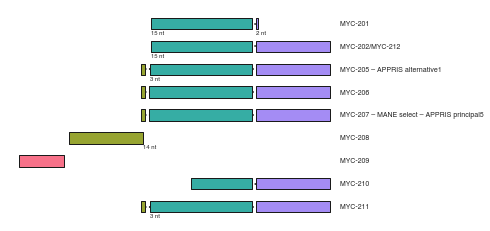

In [107]:
tfs["MYC"].exon_diagram()

## 8. calculate domains that are affected compared to null

In [108]:
len(df.gene_symbol.unique())

906

In [109]:
len(df.ref_iso.unique())

906

In [110]:
len(df.alt_iso.unique())

2298

In [111]:
df['is_DBD'] = df['accession'].isin(dbd['pfam'].values) | df['accession'].str.startswith('C2H2_ZF_array')
df.head()

,gene_symbol,ref_iso,alt_iso,accession,category,start_in_ref_iso,end_in_ref_iso,length,deletion,insertion,frameshift,is_DBD
0,PRDM16,PRDM16-201,PRDM16-203,PF00096,Pfam_domain,229,251,22,0,0,0,True
1,PRDM16,PRDM16-201,PRDM16-206,PF00096,Pfam_domain,229,251,22,0,0,0,True
2,PRDM16,PRDM16-201,PRDM16-208,PF00096,Pfam_domain,229,251,22,0,0,0,True
3,PRDM16,PRDM16-201,PRDM16-203,PF00856,Pfam_domain,94,209,115,0,0,0,False
4,PRDM16,PRDM16-201,PRDM16-206,PF00856,Pfam_domain,94,209,115,0,1,0,False


In [112]:
# TODO: move to isolib.py
df['is_affected_at_all'] = (df['deletion'] + df['insertion'] + df['frameshift']) > 0
for frac in [1.0, 0.9, 0.5, 0.1]:
    df[f"is_affected_{frac * 100:.0f}pct"] = (df['deletion'] + df['insertion'] + df['frameshift']) >= frac * df['length']

dbd_acc = set(dbd['pfam'].values).union(
            set(df['accession'][df['accession'].str.startswith('C2H2_ZF_array')].unique())
            )

In [113]:
dbd['clan'] = dbd['pfam'].map(clans)
dbd['num_genes'] = dbd['pfam'].map(df.groupby('accession')['gene_symbol'].size())

In [114]:
def is_DBD(domain):
    return (domain.accession in dbd['pfam'].values) or domain.accession.startswith('C2H2_ZF_array')

n_aa_dbd = [len(dom) for tf in tfs.values() for dom in tf.reference_isoform.aa_seq_features if is_DBD(dom)]
n_aa_pfam = [len(dom) for tf in tfs.values() for dom in tf.reference_isoform.aa_seq_features if not is_DBD(dom) and dom.category == 'Pfam_domain']
n_aa_effector = [len(dom) for tf in tfs.values() for dom in tf.reference_isoform.aa_seq_features if not is_DBD(dom) and dom.category == 'effector_domain']
n_aa_nls = [len(dom) for tf in tfs.values() for dom in tf.reference_isoform.aa_seq_features if not is_DBD(dom) and dom.category == 'UniProt motif']

In [115]:
df.loc[df['accession'].str.startswith('C2H2_ZF_array'), 'accession'] = 'C2H2_ZF_array'
doms = (df.loc[(df['category'] == 'Pfam_domain') | 
              (df['category'] == 'ZF_array'), :]
              .groupby('accession')
              ['alt_iso']
              .nunique()
              .to_frame(name='n_alt_iso'))
for c in [c for c in df.columns if c.startswith('is_affected_')]:
    doms['n_' + c] = (df.loc[(df['category'] == 'Pfam_domain') |
                        (df['category'] == 'ZF_array'), :]
                        .groupby(['accession', 'alt_iso'])
                        [c]
                        .any()
                        .sum(level='accession'))
    doms['f_' + c] = doms['n_' + c] / doms['n_alt_iso']
doms = doms.sort_values('n_alt_iso', ascending=False)

In [116]:
%%time
# again, explicitly compare ref v alt
df_null = pd.concat([g.null_fraction_per_aa_feature(ref_isos[g.name]) for g in tfs.values() if g.has_MANE_select_isoform])

df = pd.merge(df, df_null, how='left', on=['gene_symbol', 'ref_iso', 'alt_iso', 'length'])

CPU times: user 2min 22s, sys: 183 ms, total: 2min 22s
Wall time: 2min 22s


In [117]:
def prob_or(probabilities):
    return 1 - (np.prod(1 - probabilities))
        

def null_quantile(values, q):
    n = len(values.values)
    for i, v in enumerate(PoiBin(values.values).cdf(range(n + 1))):
        if v >= q:
            return i / n


for null_col in [c for c in df.columns if c.startswith('null_fraction_')]:
    null_p = (df.loc[(df['category'] == 'Pfam_domain') |
                    (df['category'] == 'ZF_array'), :]
                .groupby(['accession', 'alt_iso'])
                [null_col]
                .apply(prob_or))
    doms[null_col + '_99CI_low'] = null_p.groupby('accession').apply(null_quantile, 0.01)
    doms[null_col + '_99CI_high'] = null_p.groupby('accession').apply(null_quantile, 0.99)
    doms[null_col + '_center'] = null_p.groupby('accession').apply(null_quantile, 0.5)

In [118]:
doms['is_DBD'] = doms.index.isin(dbd['pfam'].values) | (doms.index == 'C2H2_ZF_array')
# Use the custom DBD names
doms.loc[doms['is_DBD'], 'domain_name'] = doms[doms['is_DBD']].index.map(dbd.set_index('pfam')['dbd'])
doms.loc[~doms['is_DBD'], 'domain_name'] = doms[~doms['is_DBD']].index.map(pfam.set_index('pfam_accession')['name'])
doms.loc[doms.index == 'C2H2_ZF_array', 'domain_name'] = ['C2H2 ZF array']

In [119]:
dom_affected_levels = [c[5:] for c in doms.columns if c.startswith('f_is_affected_')]
level_desc = {'affected_at_all': 'at least partial domain removal',
 'affected_100pct': '100% removal',
 'affected_90pct': '90% removal',
 'affected_50pct': '50% removal',
 'affected_10pct': '10% removal'}

In [120]:
# all domains, all DBD, non-DBD
doms = df.groupby('is_DBD')['alt_iso'].nunique().to_frame(name='n_alt_iso')
for c in [c for c in df.columns if c.startswith('is_affected_')]:
    doms['n_' + c] = (df.groupby(['is_DBD', 'alt_iso'])
                        [c]
                        .any()
                        .sum(level='is_DBD'))
    doms['f_' + c] = doms['n_' + c] / doms['n_alt_iso']


doms = doms.sort_values('n_alt_iso', ascending=False)
    
def prob_or(probabilities):
    return 1 - (np.prod(1 - probabilities))
        

def null_quantile(values, q):
    n = len(values.values)
    for i, v in enumerate(PoiBin(values.values).cdf(range(n + 1))):
        if v >= q:
            return i / n


for null_col in [c for c in df.columns if c.startswith('null_fraction_')]:
    null_p = (df.groupby(['is_DBD', 'alt_iso'])
                [null_col]
                .apply(prob_or))
    doms[null_col + '_99CI_low'] = null_p.groupby('is_DBD').apply(null_quantile, 0.01)
    doms[null_col + '_99CI_high'] = null_p.groupby('is_DBD').apply(null_quantile, 0.99)
    doms[null_col + '_center'] = null_p.groupby('is_DBD').apply(null_quantile, 0.5)
doms.head()

,n_alt_iso,n_is_affected_at_all,f_is_affected_at_all,n_is_affected_100pct,f_is_affected_100pct,n_is_affected_90pct,f_is_affected_90pct,n_is_affected_50pct,f_is_affected_50pct,n_is_affected_10pct,...,null_fraction_affected_100pct_center,null_fraction_affected_90pct_99CI_low,null_fraction_affected_90pct_99CI_high,null_fraction_affected_90pct_center,null_fraction_affected_50pct_99CI_low,null_fraction_affected_50pct_99CI_high,null_fraction_affected_50pct_center,null_fraction_affected_10pct_99CI_low,null_fraction_affected_10pct_99CI_high,null_fraction_affected_10pct_center
is_DBD,,,,,,,,,,,,,,,,,,,,,
False,2265,1733.0,0.765121,1002.0,0.442384,1037.0,0.457837,1258.0,0.555408,1597.0,...,0.562031,0.556733,0.585430,0.571302,0.610155,0.639294,0.624724,0.683444,0.712583,0.698013
True,2129,990.0,0.465007,724.0,0.340066,734.0,0.344763,816.0,0.383279,947.0,...,0.418976,0.411461,0.441522,0.426491,0.450446,0.482386,0.466416,0.508690,0.542508,0.525599


In [121]:
df['category_a'] = np.nan
df.loc[df['is_DBD'], 'category_a'] = 'DBD'
df.loc[(df['category'] == 'Pfam_domain') & ~df['is_DBD'], 'category_a'] = 'Other Pfam domain'
df.loc[(df['category'] == 'effector_domain'), 'category_a'] = 'Effector domain'
df.loc[(df['category'] == 'UniProt motif'), 'category_a'] = 'NLS/NES'

In [122]:
# split by domain type
doms = df.groupby('category_a')['alt_iso'].nunique().to_frame(name='n_alt_iso')
for c in [c for c in df.columns if c.startswith('is_affected_')]:
    doms['n_' + c] = (df.groupby(['category_a', 'alt_iso'])
                        [c]
                        .any()
                        .sum(level='category_a'))
    doms['f_' + c] = doms['n_' + c] / doms['n_alt_iso']
doms = doms.sort_values('n_alt_iso', ascending=False)

    
def prob_or(probabilities):
    return 1 - (np.prod(1 - probabilities))
        

def null_quantile(values, q):
    n = len(values.values)
    for i, v in enumerate(PoiBin(values.values).cdf(range(n + 1))):
        if v >= q:
            return i / n


for null_col in [c for c in df.columns if c.startswith('null_fraction_')]:
    null_p = (df.groupby(['category_a', 'alt_iso'])
                [null_col]
                .apply(prob_or))
    doms[null_col + '_99CI_low'] = null_p.groupby('category_a').apply(null_quantile, 0.01)
    doms[null_col + '_99CI_high'] = null_p.groupby('category_a').apply(null_quantile, 0.99)
    doms[null_col + '_center'] = null_p.groupby('category_a').apply(null_quantile, 0.5)

data = doms.copy()

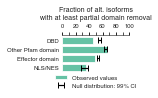

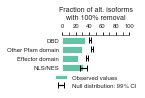

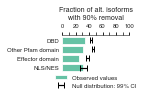

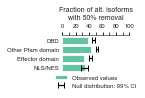

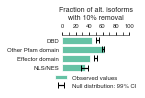

In [123]:
for level in dom_affected_levels:
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(1.2, 0.7)

        ax.barh(data.index, 
                data[f'f_is_{level}'].values * 100,
                label='Observed values',
                color=sns.color_palette("Set2")[0])
        ax.errorbar(y=data.index,
                x=data[f'null_fraction_{level}_center'].values * 100,
                xerr=[(data[f'null_fraction_{level}_center'] - data[f'null_fraction_{level}_99CI_low']).values * 100,
                        (data[f'null_fraction_{level}_99CI_high'] - data[f'null_fraction_{level}_center']).values * 100],
                                fmt='none',
                                capsize=3,
                                color='black',
                                label='Null distribution: 99% CI')
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.55), frameon=False)
        ax.set_xlim(0, 100)
        ax.set_ylim(ax.get_ylim()[::-1])
        ax.yaxis.set_tick_params(length=0)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.xaxis.tick_top()
        ax.set_yticklabels(["DBD", "Other Pfam domain", "Effector domain", "NLS/NES"])
        ax.set_xlabel(f'Fraction of alt. isoforms\nwith {level_desc[level]}')
        ax.xaxis.set_label_position('top')
        ax.set_xticks(range(0, 101, 20))
        ax.set_xticks(range(0, 101, 10), minor=True)
        plt.savefig(f'../../figures/fig1/domain_categories_{level}.resized.pdf'.format(level),
                bbox_inches='tight')

In [124]:
print("total # ref. isoforms w/ annotated NLS/NES: %s" % (len(df[df["category"] == "UniProt motif"].ref_iso.unique())))
print("total # ref. isoforms w/ annotated NLS: %s" % (len(df[(df["category"] == "UniProt motif") &
                                                             (df["accession"].str.contains("NLS"))].ref_iso.unique())))
print("total # ref. isoforms w/ annotated NES: %s" % (len(df[(df["category"] == "UniProt motif") &
                                                             (df["accession"].str.contains("NES"))].ref_iso.unique())))

total # ref. isoforms w/ annotated NLS/NES: 73
total # ref. isoforms w/ annotated NLS: 69
total # ref. isoforms w/ annotated NES: 12


### more granular plots

In [125]:
doms = (df.loc[(df['category'] == 'Pfam_domain') | 
              (df['category'] == 'ZF_array'), :]
              .groupby('accession')
              ['alt_iso']
              .nunique()
              .to_frame(name='n_alt_iso'))
for c in [c for c in df.columns if c.startswith('is_affected_')]:
    doms['n_' + c] = (df.loc[(df['category'] == 'Pfam_domain') |
                        (df['category'] == 'ZF_array'), :]
                        .groupby(['accession', 'alt_iso'])
                        [c]
                        .any()
                        .sum(level='accession'))
    doms['f_' + c] = doms['n_' + c] / doms['n_alt_iso']
doms = doms.sort_values('n_alt_iso', ascending=False)


for null_col in [c for c in df.columns if c.startswith('null_fraction_')]:
    null_p = (df.loc[(df['category'] == 'Pfam_domain') |
                    (df['category'] == 'ZF_array'), :]
                .groupby(['accession', 'alt_iso'])
                [null_col]
                .apply(prob_or))
    doms[null_col + '_99CI_low'] = null_p.groupby('accession').apply(null_quantile, 0.01)
    doms[null_col + '_99CI_high'] = null_p.groupby('accession').apply(null_quantile, 0.99)
    doms[null_col + '_center'] = null_p.groupby('accession').apply(null_quantile, 0.5)

In [126]:
doms['is_DBD'] = doms.index.isin(dbd['pfam'].values) | (doms.index == 'C2H2_ZF_array')
# Use the custom DBD names
doms.loc[doms['is_DBD'], 'domain_name'] = doms[doms['is_DBD']].index.map(dbd.set_index('pfam')['dbd'])
doms.loc[~doms['is_DBD'], 'domain_name'] = doms[~doms['is_DBD']].index.map(pfam.set_index('pfam_accession')['name'])
doms.loc[doms.index == 'C2H2_ZF_array', 'domain_name'] = ['C2H2 ZF array']
doms.head()

,n_alt_iso,n_is_affected_at_all,f_is_affected_at_all,n_is_affected_100pct,f_is_affected_100pct,n_is_affected_90pct,f_is_affected_90pct,n_is_affected_50pct,f_is_affected_50pct,n_is_affected_10pct,...,null_fraction_affected_90pct_99CI_high,null_fraction_affected_90pct_center,null_fraction_affected_50pct_99CI_low,null_fraction_affected_50pct_99CI_high,null_fraction_affected_50pct_center,null_fraction_affected_10pct_99CI_low,null_fraction_affected_10pct_99CI_high,null_fraction_affected_10pct_center,is_DBD,domain_name
accession,,,,,,,,,,,,,,,,,,,,,
C2H2_ZF_array,925,519.0,0.561081,407.0,0.440000,411.0,0.444324,446.0,0.482162,502.0,...,0.499459,0.483243,0.503784,0.538378,0.521081,0.567568,0.609730,0.588108,True,C2H2 ZF array
PF01352,540,244.0,0.451852,111.0,0.205556,119.0,0.220370,177.0,0.327778,197.0,...,0.553704,0.525926,0.514815,0.568519,0.542593,0.527778,0.583333,0.555556,False,KRAB box
PF00046,192,75.0,0.390625,52.0,0.270833,53.0,0.276042,62.0,0.322917,74.0,...,0.411458,0.354167,0.328125,0.447917,0.390625,0.369792,0.494792,0.432292,True,Homeodomain
PF00096,165,56.0,0.339394,56.0,0.339394,56.0,0.339394,56.0,0.339394,56.0,...,0.442424,0.387879,0.345455,0.454545,0.400000,0.351515,0.466667,0.406061,True,C2H2 ZF
PF00010,134,43.0,0.320896,17.0,0.126866,18.0,0.134328,22.0,0.164179,34.0,...,0.328358,0.261194,0.223881,0.365672,0.291045,0.268657,0.417910,0.343284,True,bHLH


In [128]:
cutoff = 30

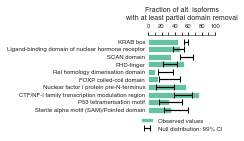

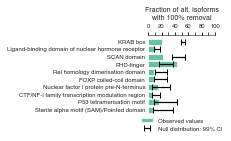

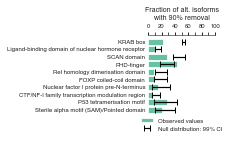

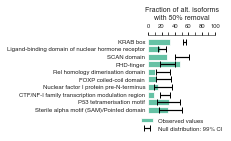

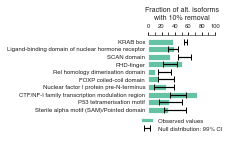

In [129]:
for level in dom_affected_levels:

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(1.2, 1.5)
    data = doms.loc[~doms['is_DBD'] &
                    (doms['n_alt_iso'] >= cutoff) &
                     ~(doms.index.map(clans) == 'CL0361'), :].copy()
    ax.barh(data.index, 
            data[f'f_is_{level}'].values * 100,
            label='Observed values',
            color=sns.color_palette("Set2")[0])
    ax.errorbar(y=data.index,
                x=data[f'null_fraction_{level}_center'].values * 100,
                xerr=[(data[f'null_fraction_{level}_center'] - data[f'null_fraction_{level}_99CI_low']).values * 100,
                      (data[f'null_fraction_{level}_99CI_high'] - data[f'null_fraction_{level}_center']).values * 100],
                fmt='none',
                capsize=3,
                color='black',
                label='Null distribution: 99% CI')
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), frameon=False)
    ax.set_yticklabels(data['domain_name'].values)
    ax.set_xlim(0, 100)
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.yaxis.set_tick_params(length=0)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.xaxis.tick_top()
    ax.set_xlabel(f'Fraction of alt. isoforms\nwith {level_desc[level]}')
    ax.xaxis.set_label_position('top')
    ax.set_xticks(range(0, 101, 20))
    ax.set_xticks(range(0, 101, 10), minor=True)
    plt.savefig('../../figures/fig1/other_domain_partial_removal.pdf',
                bbox_inches='tight')